<a href="https://colab.research.google.com/github/abhinavreddy910/Domain-Adaptation/blob/main/Train_on_target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
#import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from itertools import cycle

In [ ]:
torch.cuda.is_available()

False

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
transform = transforms.Compose([transforms.Resize(224),transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])

In [ ]:
trainset_dslr = datasets.ImageFolder('/content/gdrive/MyDrive/Colab Notebooks/DA/Datasets/Office /dslr/images', transform=transform)  # 498 Images

trainset_dslr,validset_dslr = torch.utils.data.random_split(trainset_dslr, [398,100])

trainloader_dslr = torch.utils.data.DataLoader(trainset_dslr, batch_size=32,shuffle=True)
validloader_dslr = torch.utils.data.DataLoader(validset_dslr, batch_size=32,shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


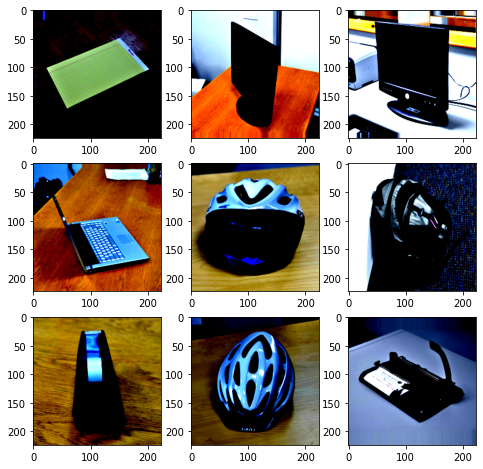

In [ ]:
trainiter = iter(trainloader_dslr)
train_images, labels = trainiter.next()
plt.figure(figsize=(8,8))
for i in range(1,10):
  image = train_images[i].numpy();
  image = np.transpose(image, (1, 2, 0))
  plt.subplot(3,3,i)
  plt.imshow(image)
 
plt.show()

In [ ]:
alexnet_model = torch.hub.load('pytorch/vision:v0.9.0', 'alexnet', pretrained=True)
alexnet_model

Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to /root/.cache/torch/hub/v0.9.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
alexnet_model.classifier[6] = nn.Identity()

In [ ]:
alexnet_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
class GradReverse(torch.autograd.Function):

    @staticmethod
    def forward(self, x):
        return x

    @staticmethod
    def backward(self, grad_output):
        return (-1 * grad_output)   

def grad_reverse(x):
    return GradReverse()(x)


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.alexnet = alexnet_model

        self.adaptation_layer = nn.Sequential(
            nn.Linear(4096 , 256),
            nn.ReLU(),
            nn.Dropout(0.2),
        )

        self.labelPredictor_layer = nn.Sequential(
            nn.Linear(256 , 31),
            nn.ReLU(),
            nn.Dropout(0.2),
        )

    def forward(self, x):
        x = self.alexnet(x)
        x = self.adaptation_layer(x)
        
        x = self.labelPredictor_layer(x)

        return x    

In [ ]:
model = Model()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([
                {'params': model.adaptation_layer.parameters()},
                {'params': model.labelPredictor_layer.parameters()},
                {'params': model.alexnet.parameters(), 'lr': 7e-6 }
            ], lr = 7e-5)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for epoch in range(35):  

    train_total = 0.0
    train_correct = 0.0
    tl = 0.0

    model.train()
    for data in trainloader_dslr:   
        
        # get the inputs; data is a list of [image, label]
        images, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        y = model(images)

        loss = criterion(y, labels) 
        loss.backward()
        
        optimizer.step()

        _, predicted = torch.max(y.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        tl += loss.item()
        
    # Calculate training stats
    train_accuracy.append(100 * train_correct / train_total)
    train_loss.append(tl / train_total);



    val_total = 0.0       
    val_correct = 0.0
    vl = 0.0

    model.eval()
    with torch.no_grad():
         for data in validloader_dslr:   
                images, labels = data

                y = model(images)
                loss = criterion(y, labels)

                _, predicted = torch.max(y.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                vl += loss.item()

    val_accuracy.append(100 * val_correct / val_total)
    val_loss.append(vl / val_total)


    scheduler.step() 

    print('Epoch: %d  -  loss: %.3f  -  accuracy: %.3f  -  val_loss: %.3f  -  val_accuracy: %.3f' %(epoch + 1,train_loss[-1],train_accuracy[-1],val_loss[-1],val_accuracy[-1])) 
                
print('\nFinished Training')

Epoch: 1  -  loss: 0.110  -  accuracy: 9.799  -  val_loss: 0.124  -  val_accuracy: 28.000
Epoch: 2  -  loss: 0.097  -  accuracy: 30.905  -  val_loss: 0.113  -  val_accuracy: 42.000
Epoch: 3  -  loss: 0.081  -  accuracy: 46.734  -  val_loss: 0.093  -  val_accuracy: 57.000
Epoch: 4  -  loss: 0.066  -  accuracy: 57.286  -  val_loss: 0.070  -  val_accuracy: 68.000
Epoch: 5  -  loss: 0.055  -  accuracy: 63.317  -  val_loss: 0.049  -  val_accuracy: 77.000
Epoch: 6  -  loss: 0.047  -  accuracy: 67.588  -  val_loss: 0.035  -  val_accuracy: 87.000
Epoch: 7  -  loss: 0.043  -  accuracy: 70.352  -  val_loss: 0.033  -  val_accuracy: 88.000
Epoch: 8  -  loss: 0.040  -  accuracy: 70.854  -  val_loss: 0.030  -  val_accuracy: 91.000
Epoch: 9  -  loss: 0.033  -  accuracy: 74.874  -  val_loss: 0.031  -  val_accuracy: 92.000
Epoch: 10  -  loss: 0.031  -  accuracy: 77.387  -  val_loss: 0.023  -  val_accuracy: 92.000
Epoch: 11  -  loss: 0.029  -  accuracy: 78.643  -  val_loss: 0.018  -  val_accuracy: 94.00

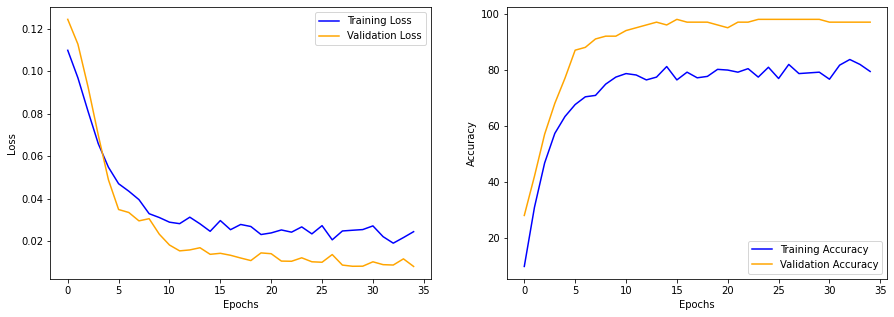

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (15,5))

ax[0].plot(train_loss,label='Training Loss',Color='blue')
ax[0].plot(val_loss,label='Validation Loss',Color='orange')
ax[0].set(xlabel='Epochs', ylabel='Loss')
ax[0].legend()

ax[1].plot(train_accuracy,label='Training Accuracy',Color='blue')
ax[1].plot(val_accuracy,label='Validation Accuracy',Color='orange')
ax[1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1].legend()